In [ ]:
# ! pip install spikeinterface
# ! pip install probeinterface

In [ ]:
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import datajoint as dj
import spikeinterface
import spikeinterface.extractors as se
from workflow.pipeline import ephys, probe, culture
from workflow.utils.ingestion_utils import El2ROW
from workflow.utils.paths import (
    get_processed_root_data_dir,
)

[2023-11-29 13:25:05,263][INFO]: Connecting utah-worker@db.datajoint.com:3306
[2023-11-29 13:25:05,822][INFO]: Connected utah-worker@db.datajoint.com:3306


In [ ]:
SORTER_DOCKER_MAP = dict(
    combinato="combinato",
    herdingspikes="herdingspikes",
    klusta="klusta",
    mountainsort4="mountainsort4",
    mountainsort5="mountainsort5",
    pykilosort="pykilosort",
    spykingcircus="spyking-circus",
    spykingcircus2="spyking-circus2",
    tridesclous="tridesclous",
    yass="yass",
    # Matlab compiled sorters:
    hdsort="hdsort-compiled",
    ironclust="ironclust-compiled",
    kilosort="kilosort-compiled",
    kilosort2="kilosort2-compiled",
    kilosort2_5="kilosort2_5-compiled",
    kilosort3="kilosort3-compiled",
    waveclus="waveclus-compiled",
    waveclus_snippets="waveclus-compiled",
)  # available sorters in SpikeInterface

In [ ]:
query = culture.Experiment & "organoid_id IN ('O13', 'O14', 'O15', 'O16')"
query

organoid_id e.g. O17,experiment_start_time,experiment_end_time,user,lineage_id de-identified code (e.g. hmau001),induction_culture_date,induction_culture_plate,post_induction_culture_date,post_induction_culture_plate,isolated_rosette_culture_date Date for isolating the rosette,isolated_rosette_culture_plate,organoid_culture_date,organoid_culture_plate,drug_name,drug_concentration concentration in uM,"experiment_plan e.g. mrna lysate, oct, protein lysate, or matrigel embedding, ephys, tracing"
O13,2023-06-08 19:05:00,2023-06-08 23:35:00,None,None,None,None,None,None,None,None,None,None,4-AP,100.0,ephys
O13,2023-06-08 23:35:00,2023-06-09 10:20:00,None,None,None,None,None,None,None,None,None,None,No Drug,nan,ephys
O13,2023-06-09 10:20:00,2023-06-09 15:35:00,None,None,None,None,None,None,None,None,None,None,Bicuculline,50.0,ephys
O13,2023-06-09 15:40:00,2023-06-10 14:15:00,None,None,None,None,None,None,None,None,None,None,Tetrodotoxin,1.0,ephys
O14,2023-06-08 19:05:00,2023-06-08 23:35:00,None,None,None,None,None,None,None,None,None,None,4-AP,100.0,ephys
O14,2023-06-08 23:35:00,2023-06-09 10:20:00,None,None,None,None,None,None,None,None,None,None,No Drug,nan,ephys
O14,2023-06-09 10:20:00,2023-06-09 15:35:00,None,None,None,None,None,None,None,None,None,None,Bicuculline,50.0,ephys
O14,2023-06-09 15:40:00,2023-06-10 14:15:00,None,None,None,None,None,None,None,None,None,None,Tetrodotoxin,1.0,ephys
O15,2023-06-08 19:05:00,2023-06-08 23:35:00,None,None,None,None,None,None,None,None,None,None,4-AP,100.0,ephys
O15,2023-06-08 23:35:00,2023-06-09 10:20:00,None,None,None,None,None,None,None,None,None,None,No Drug,nan,ephys


### Load data

In [ ]:
import spikeinterface as si
import spikeinterface.extractors as se

organoid_id = 'O13'
start_time = '2023-06-08 23:35'
stream_name = "RHD2000 amplifier channel"

key = (ephys.EphysSession & f"organoid_id='{organoid_id}'" & f"start_time='{start_time}'" & "session_type='spike_sorting'").fetch1("KEY")

query = (
    ephys.EphysRawFile
    & f"file_time BETWEEN '{key['start_time']}' AND '{key['end_time']}'"
)

file_times, files = query.fetch("file_time", "file", order_by="file_time")

# # data = intanrhdreader.load_file(files[0])
# # data["amplifier_channels"]

# recording = se.read_intan(files[0], stream_name=stream_name)

# # recording.get_traces(return_scaled=True)  # return values in uV
# # recording.get_times() # get timestamps
# # recording.get_time_info()  # {'sampling_frequency': 20000.0, 't_start': None, 'time_vector': None}
# recording.neo_reader
# # recording.has_time_vector()  # false
# # recording.sampling_frequency

In [ ]:
# Concatenate the data
recording = None
t_start = file_times[0]
for file in files:
    if not recording:
        recording =se.read_intan(file, stream_name=stream_name)
    else:
        recording = si.concatenate_recordings([recording, se.read_intan(file, stream_name=stream_name)])
        
recording

c:\Users\jaero\miniconda3\envs\utah_organoids\lib\site-packages\spikeinterface\core\baserecording.py:222: RuntimeWarning: overflow encountered in scalar multiply
  memory_bytes = num_samples * num_channels * dtype_size_bytes


ConcatenateSegmentRecording: 128 channels - 20.0kHz - 1 segments - 25,200,000 samples 
                             1,260.00s (21.00 minutes) - uint16 dtype - -2138734592.00 B

### Generate probe

In [ ]:
import probeinterface as pi
from probeinterface import plotting

In [ ]:
# Get probe info
probe_info = (ephys.EphysSessionProbe & key).fetch1()
probe_type = (probe.Probe & {"probe": probe_info["probe"]}).fetch1(
    "probe_type"
) # 'A1x32-6mm-100-177-H32_21mm'
manufacturer = 'neuronexus'

electrode_query = probe.ElectrodeConfig.Electrode & (
    probe.ElectrodeConfig & {"probe_type": probe_type}
)
number_of_electrodes = len(electrode_query)
unused_electrodes = [elec for elec in range(number_of_electrodes) if elec not in probe_info["used_electrodes"]]

# Filter for used electrodes. If probe_info["used_electrodes"] is None, it means all electrodes were used.
if probe_info["used_electrodes"] is not None:
    electrode_query &= (
        f'electrode IN {tuple(probe_info["used_electrodes"])}'
    )
    
electrode_df = electrode_query.fetch(format="frame").reset_index()

channel_to_electrode_map = dict(
    zip(electrode_df["channel"], electrode_df["electrode"])
)

channel_to_electrode_map = {
    f'{probe_info["port_id"]}-{int(channel):03d}': electrode
    for channel, electrode in channel_to_electrode_map.items()
}

lfp_indices = np.sort(np.array(electrode_query.fetch("channel"), dtype=int))
print(channel_to_electrode_map)

{'A-019': 0, 'A-004': 1, 'A-018': 2, 'A-005': 3, 'A-017': 4, 'A-006': 5, 'A-031': 6, 'A-008': 7, 'A-030': 8, 'A-009': 9, 'A-029': 10, 'A-010': 11, 'A-020': 12, 'A-003': 13, 'A-021': 14, 'A-002': 15, 'A-022': 16, 'A-001': 17, 'A-024': 18, 'A-015': 19, 'A-025': 20, 'A-014': 21, 'A-026': 22, 'A-013': 23, 'A-027': 24}


,x,y,contact_shapes,radius,shank_ids,contact_ids,device_channel_indices,si_units,plane_axis_x_0,plane_axis_x_1,plane_axis_y_0,plane_axis_y_1
0,0.0,0.0,circle,15.0,,0,19,um,1.0,0.0,0.0,1.0
1,0.0,100.0,circle,15.0,,1,4,um,1.0,0.0,0.0,1.0
2,0.0,200.0,circle,15.0,,2,18,um,1.0,0.0,0.0,1.0
3,0.0,300.0,circle,15.0,,3,5,um,1.0,0.0,0.0,1.0
4,0.0,400.0,circle,15.0,,4,17,um,1.0,0.0,0.0,1.0
5,0.0,500.0,circle,15.0,,5,6,um,1.0,0.0,0.0,1.0
6,0.0,600.0,circle,15.0,,6,31,um,1.0,0.0,0.0,1.0
7,0.0,700.0,circle,15.0,,7,8,um,1.0,0.0,0.0,1.0
8,0.0,800.0,circle,15.0,,8,30,um,1.0,0.0,0.0,1.0
9,0.0,900.0,circle,15.0,,9,9,um,1.0,0.0,0.0,1.0


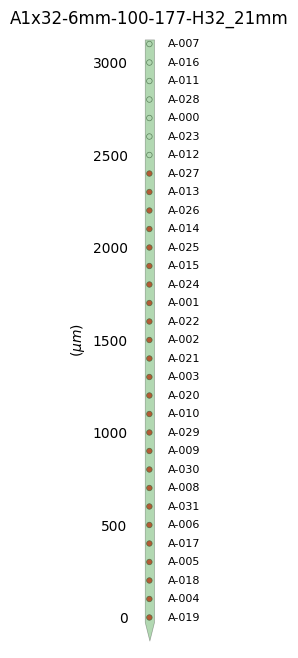

In [ ]:
# Plot the probe
fig, ax = plt.subplots(figsize=(8, 8))

# Create a session probe
# linear_probe = to_probeinterface(electrode_df)
linear_probe = pi.generate_linear_probe(num_elec=32, ypitch=100, contact_shape_params={'radius': 15})
linear_probe.set_device_channel_indices(El2ROW)

contact_colors = ['r' if e in probe_info["used_electrodes"] else 'w' for e in range(number_of_electrodes)]  # red for used channels

pi.plotting.plot_probe(linear_probe, ax=ax, contacts_colors=contact_colors)
[spine.set_visible(False) for spine in ax.spines.values()]
ax.yaxis.set_ticks_position('none')  # Remove y-axis tick marks
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("($\\mu m$)", fontsize=10)
ax.set_title(probe_type)

contact_positions = linear_probe.contact_positions
device_channel_indices = [f"{probe_info['port_id']}-{ch:03}" for ch in linear_probe.device_channel_indices]

for (x, y), txt in zip(contact_positions, device_channel_indices):
    ax.text(x + 100, y, txt, va="center", fontsize=8)

recording = recording.set_probe(linear_probe)
linear_probe.to_dataframe(complete=True) 

#### Preprocessing

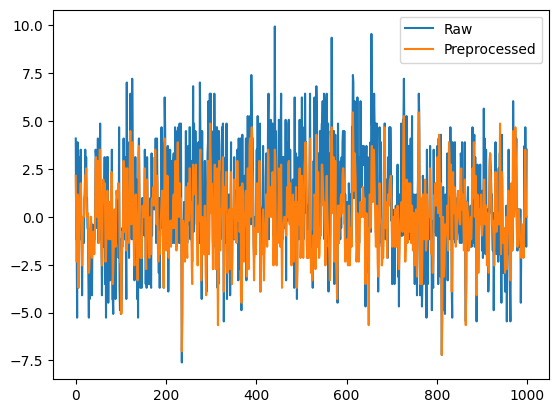

In [ ]:
from spikeinterface import preprocessing

recording = recording.remove_channels(
    remove_channel_ids=np.array([str(elec) for elec in unused_electrodes])
)  # Remove unused electrodes
recording_f = si.preprocessing.bandpass_filter(recording=recording, freq_min=300, freq_max=6000)
recording_cmr = si.preprocessing.common_reference(recording=recording_f, operator="median")

trace_raw = recording.get_traces(start_frame=100_000, end_frame=101_000, return_scaled=True)
trace_preprocessed = recording_cmr.get_traces(start_frame=100_000, end_frame=101_000, return_scaled=True)

plt.plot(trace_raw [:, 0], label='Raw')
plt.plot(trace_preprocessed[:, 0], label='Preprocessed')
plt.legend()
plt.show()

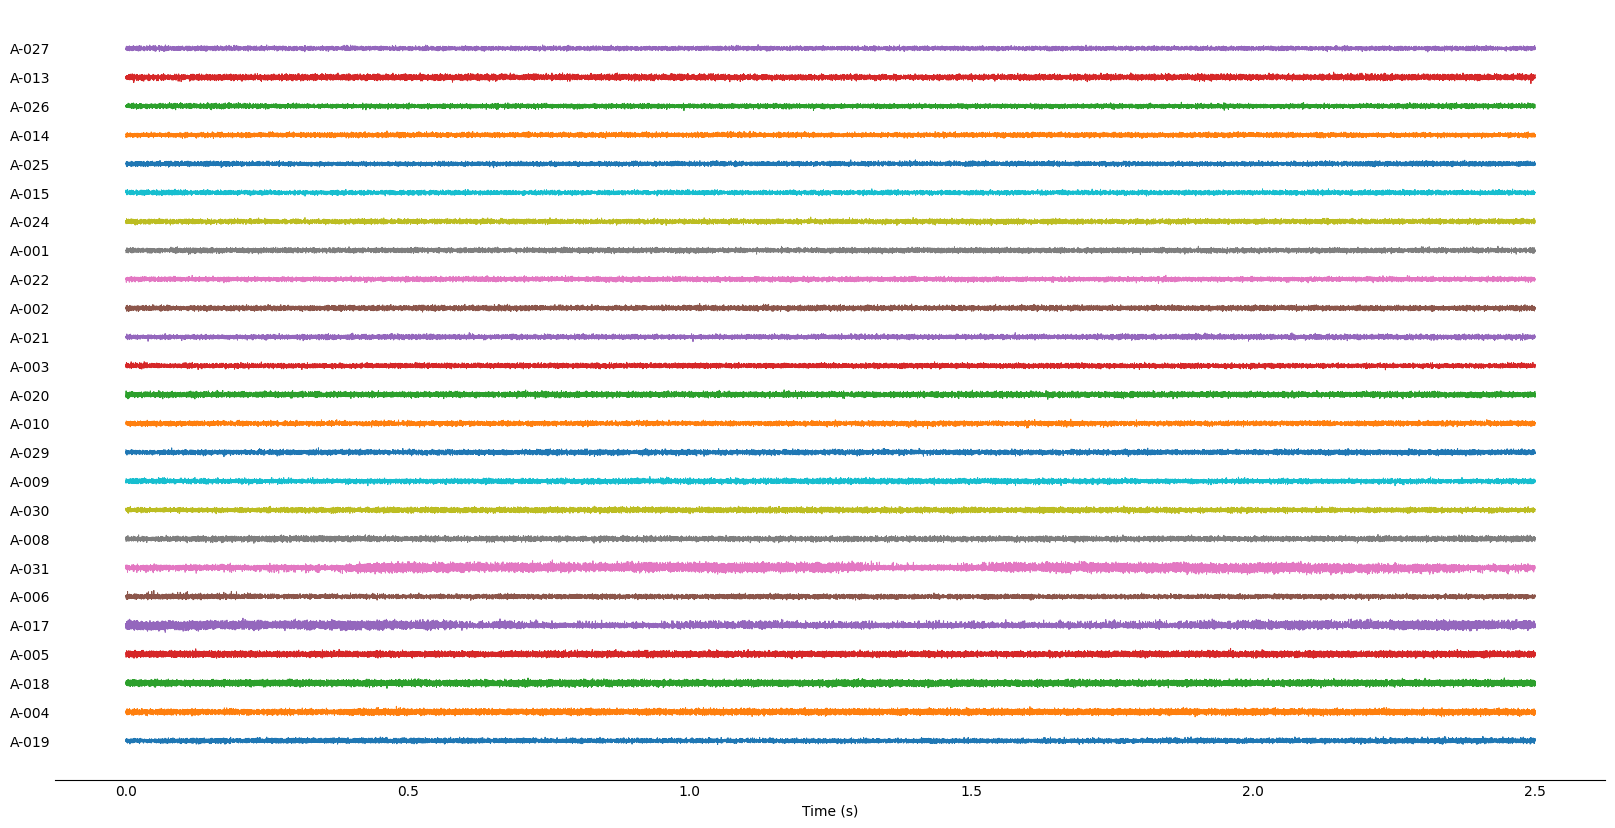

In [ ]:
import seaborn as sns
data = recording_cmr.get_traces(start_frame=50000, end_frame=100000, return_scaled=True)

fig, ax = plt.subplots(figsize=(20, 10))
ytick_loc = []
offset = 50

for i in range(data.shape[1]):
    ax.plot(np.r_[:data.shape[0]] / recording_cmr.sampling_frequency, data[:, i] + i * offset, linewidth=0.7)
    ytick_loc.append(i * offset)

ax.set_yticks(ytick_loc)
ax.set_yticklabels([device_channel_indices[i] for i in probe_info["used_electrodes"]])
ax.tick_params(length=0)
ax.set(xlabel="Time (s)")
sns.despine(right = True, left = True)
plt.show()

### Run sorter

In [ ]:
from spikeinterface.full import run_sorter

#### SpikingCircus2

In [ ]:
# !pip install hdbscan
# !pip install spikeinterface
# !pip install numba

In [ ]:
sorter_name = "spykingcircus2"
sorting_folder = get_processed_root_data_dir() / "spike_sorting" / (key["organoid_id"] + "_" + str(key["start_time"].time()).replace(":", "-") + "_" + str(key["end_time"].time()).replace(":", "-")) / sorter_name

# Run sorter. Load the sorting data if it already exists
if sorting_folder.exists():
    sorting = si.load_extractor(sorting_folder)
else:
    sorting = run_sorter(recording=recording_cmr, sorter_name=sorter_name)
    sorting.save(folder=sorting_folder)

In [ ]:
sorting.to_dict()

{'class': 'spikeinterface.core.sortingfolder.NumpyFolderSorting',
 'module': 'spikeinterface',
 'kwargs': {'folder_path': 'C:\\Users\\jaero\\Desktop\\Data\\organoids\\spike_sorting\\O13_23-35-00_00-05-00\\spykingcircus2'},
 'version': '0.99.1',
 'relative_paths': False,
 'annotations': {},
 'properties': {}}

##### Sorted results

In [ ]:
import pandas as pd
spiking_circus_output = pd.DataFrame(np.load(sorting_folder /"spikes.npy"))
spiking_circus_output

,sample_index,unit_index,segment_index
0,2,43,0
1,10,31,0
2,16,13,0
3,40,98,0
4,47,4,0
...,...,...,...
1336856,25199918,94,0
1336857,25199933,25,0
1336858,25199936,31,0
1336859,25199970,84,0


In [ ]:
# Waveform extraction
folder = 'waveform_folder'
we = si.extract_waveforms(
    recording_cmr,
    sorting,
    folder=sorting_folder / "waveform",
    ms_before=1.5,
    ms_after=2.,
    max_spikes_per_unit=500,
    overwrite=True,
    # load_if_exists=True
)
print(we)

In [ ]:
ax = si.widgets.plot_unit_templates(we, unit_ids=sorting.unit_ids[:10], ncols=5)

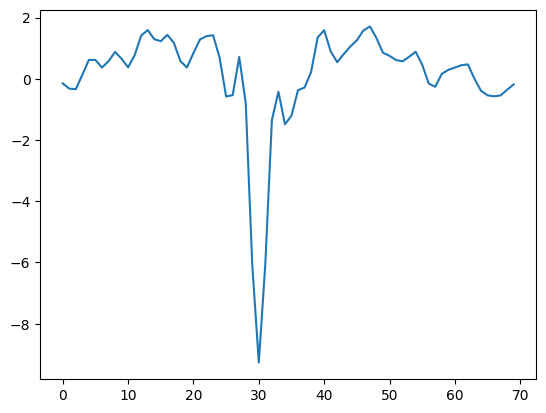

In [ ]:
unit_id = 1
si.widgets.plot_unit_waveforms(we, unit_ids=[sorting.unit_ids[unit_id]])

fig, ax = plt.subplots()
template = we.get_template(unit_id=sorting.unit_ids[unit_id], mode='average')
ax.plot(template[:, 0])
plt.show()

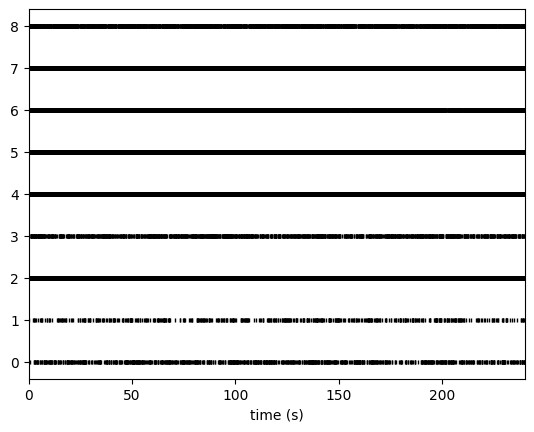

In [ ]:
si.widgets.plot_rasters(sorting)

#### Kilosort2_5

In [ ]:
# !pip install docker
# !pip install cuda-python

In [ ]:
sorter_name="kilosort2"
sorting_folder = get_processed_root_data_dir() / (key["organoid_id"] + "-" + str(key["start_time"].time()).replace(":", "-")) / sorter_name

sorting_kilosort = run_sorter(
    recording=recording_cmr,
    sorter_name=sorter_name, 
    output_folder=sorting_folder,
    remove_existing_folder=True,
    verbose=True,
    docker_image=True,
)